# Invert three surveys line for a thin plate using the surrogate model

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em_three_lines_transmitters.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/vtem_max

In [3]:
import pickle
import numpy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cofi
import arviz
from forward_lib import (
    problem_setup, 
    system_spec, 
    survey_setup, 
    ForwardWrapper, 
    plot_predicted_profile, 
    plot_transient, 
    plot_plate_faces, 
    plot_plate_faces_single
)

numpy.random.seed(42)

## Background

This example inverts three survey line of VTEM max data using the vertical component for a thin plate target. It thus becomes possible to invert for the easting,northing, depth of the plate reference point, the plate dip and plate azimuth. Solving the forward problem, that is  calculating the objective function, usess the surrogate model that has been created by the [Kriging approach](./three_survey_lines_surrogate_model_creation.ipynb) applied to the [latin hypercube samples](three_survey_lines_latin_hypercube_sampling.ipynb) of the objective function.

## Problem definition

In [4]:
tx_min = 115
tx_max = 281
tx_interval = 15
ty_min = 25
ty_max = 176
ty_interval = 75
tx_points = numpy.arange(tx_min, tx_max, tx_interval)
ty_points = numpy.arange(ty_min, ty_max, ty_interval)
n_transmitters = len(tx_points) * len(ty_points)
tx, ty = numpy.meshgrid(tx_points, ty_points)
tx = tx.flatten()
ty = ty.flatten()

In [5]:
fiducial_id = numpy.arange(len(tx))
line_id = numpy.zeros(len(tx), dtype=int)
line_id[ty==ty_points[0]] = 0
line_id[ty==ty_points[1]] = 1
line_id[ty==ty_points[2]] = 2

In [6]:
survey_setup = {
    "tx": tx,                                                   # transmitter easting/x-position
    "ty": ty,                                                   # transmitter northing/y-position
    "tz": numpy.array([50]*n_transmitters),                     # transmitter height/z-position
    "tazi": numpy.deg2rad(numpy.array([90]*n_transmitters)),    # transmitter azimuth
    "tincl": numpy.deg2rad(numpy.array([6]*n_transmitters)),    # transmitter inclination
    "rx": tx,                                                   # receiver easting/x-position
    "ry": numpy.array([100]*n_transmitters),                    # receiver northing/y-position
    "rz": numpy.array([50]*n_transmitters),                     # receiver height/z-position
    "trdx": numpy.array([0]*n_transmitters),                    # transmitter receiver separation inline
    "trdy": numpy.array([0]*n_transmitters),                    # transmitter receiver separation crossline
    "trdz": numpy.array([0]*n_transmitters),                    # transmitter receiver separation vertical
    "fiducial_id": fiducial_id,                                 # unique id for each transmitter
    "line_id": line_id                  # id for each line
}

In [7]:
true_model = {
    "res": numpy.array([300, 1000]), 
    "thk": numpy.array([20]), 
    "peast": numpy.array([175]), 
    "pnorth": numpy.array([100]), 
    "ptop": numpy.array([30]), 
    "pres": numpy.array([0.1]), 
    "plngth1": numpy.array([100]), 
    "plngth2": numpy.array([100]), 
    "pwdth1": numpy.array([0.1]), 
    "pwdth2": numpy.array([90]), 
    "pdzm": numpy.array([75]),
    "pdip": numpy.array([60])
}

In [8]:
forward = ForwardWrapper(true_model, problem_setup, system_spec, survey_setup,
                         ["pdip","pdzm", "peast", "ptop", "pwdth2"], data_returned=["vertical"])

['pdip', 'pdzm', 'peast', 'ptop', 'pwdth2']


In [9]:
# check the order of parameters in a model vector
forward.params_to_invert

['pdip', 'pdzm', 'peast', 'ptop', 'pwdth2']

In [10]:
true_param_value = numpy.array([60.,65., 175., 30., 90.])

##  Ensemble method using the surrogate model

In [11]:
sm = None
filename = "kriging_surrogate_model.pkl"
with open(filename, "rb") as f:
   sm = pickle.load(f)

**Initialise a model for inversion**

In [12]:
init_param_value = numpy.array([45, 90, 160, 35, 80])
m_min = numpy.array([15, 35, 155, 30, 65])
m_max = numpy.array([75, 145, 185, 40, 115])

**Define helper functions for CoFI**

In [13]:
def my_objective(model):
    val=sm.predict_values(numpy.array([model]))[0][0]
    if val<1e-3:
        return 1e-3
    else:
        return val
        
def my_log_likelihood(model):
    return -0.5 * my_objective(model)

def my_log_prior(model):    # uniform distribution
    for i in range(len(model)):
        if model[i] < m_min[i] or model[i] > m_max[i]: return -numpy.inf
    return 0.0 # model lies within bounds -> return log(1)

**Define CoFI problem**

In [19]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)

**Define CoFI options**

In [20]:
inv_options = cofi.InversionOptions()
inv_options.set_tool("neighpy")
inv_options.suggest_solver_params()

Current backend tool neighpy has the following solver-specific parameters:
Required parameters:
{'direct_search_nr', 'bounds', 'direct_search_n', 'direct_search_ns', 'direct_search_ni', 'appraisal_n_resample', 'appraisal_n_walkers'}
Optional parameters & default settings:
-- nothing --


In [23]:

inv_options.set_params(
    direct_search_ni=1000,
    direct_search_ns=100,
    direct_search_nr=20,
    direct_search_n=10,
    bounds=numpy.array([m_min, m_max]).T,
    appraisal_n_resample=10000,
    appraisal_n_walkers=4
)

######## Run it
inv = cofi.Inversion(my_problem, inv_options)
inv_result = inv.run()

######## Check result
print(f"The inversion result from `neighpy`:")
inv_result.summary()

NAI - Initial Random Search


NAII - Random Walk:  99%|█████████▉| 2484/2500 [00:15<00:00, 162.38it/s]

The inversion result from `neighpy`:
Summary for inversion result
SUCCESS
----------------------------
model: [ 50.33652189  63.84086878 180.80955386  37.12873473  93.7771508 ]
direct_search_samples: [[ 44.64282028 102.7355562  162.68405127  32.84672687  73.07966009]
 [ 68.55896684  78.01045439 180.00881202  38.45509319  93.03244934]
 [ 17.35444759 131.01896612 166.40456451  32.21063981  92.18911795]
 ...
 [ 50.48322203  63.72995743 180.65884901  37.08826725  93.50491678]
 [ 50.48861473  63.73330512 180.65995784  37.08300926  93.50776841]
 [ 50.48241228  63.73192926 180.65681872  37.08738941  93.50581068]]
direct_search_objectives: [2.91229184e+04 1.17647969e+04 1.97445795e+05 ... 1.00000000e-03
 1.00000000e-03 1.00000000e-03]
appraisal_samples: [[ 57.57099559  76.60420895 181.62956354  36.95468863  93.23757564]
 [ 51.10208111  69.02089624 176.95567185  36.38051284  93.3853501 ]
 [ 53.87227478  73.84953071 176.52817135  36.48516269  92.56286941]
 ...
 [ 47.45067354  58.52924734 184.721

NAII - Random Walk: 100%|██████████| 2500/2500 [00:15<00:00, 162.99it/s]


## Plotting

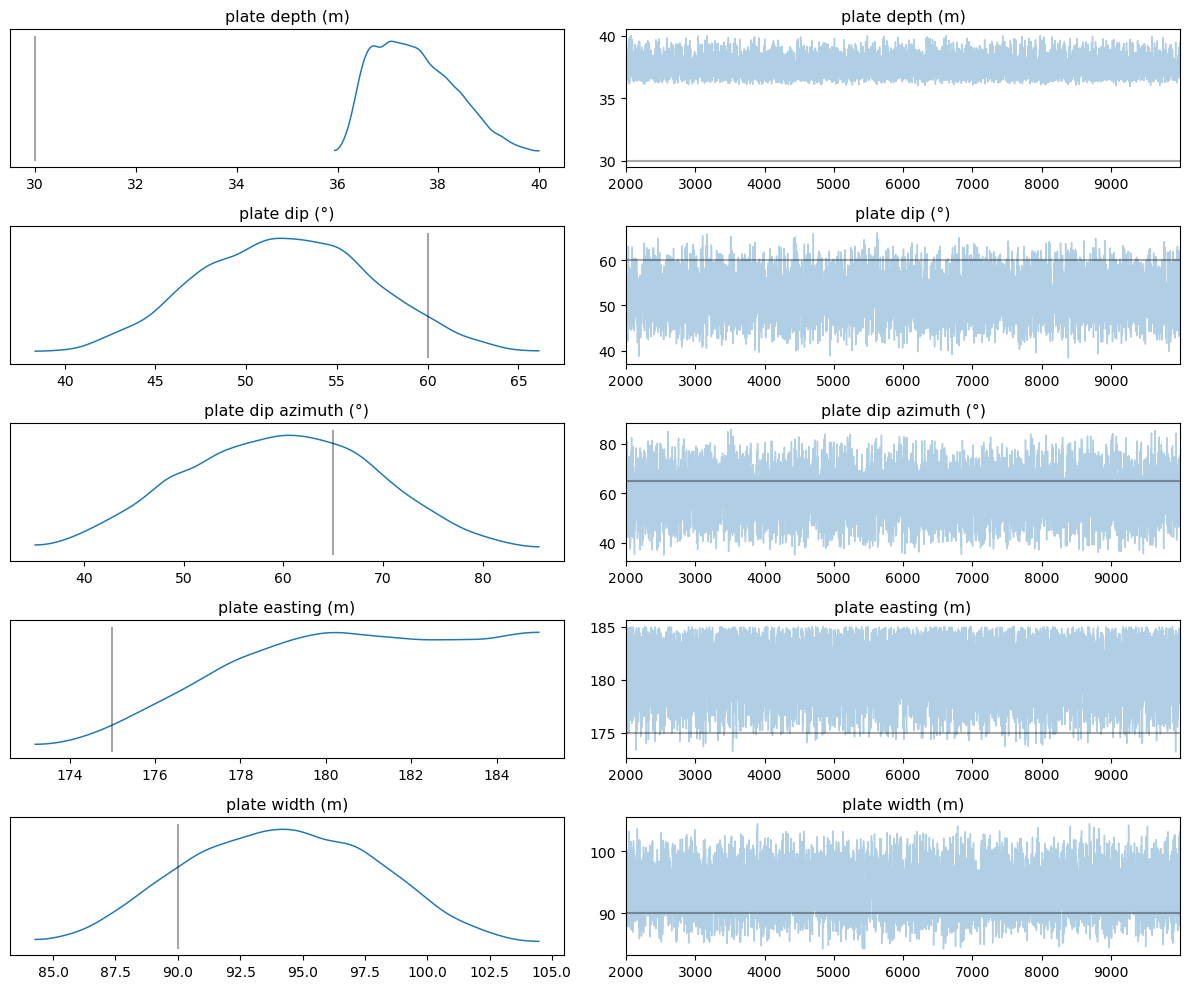

In [39]:
arviz.style.use("default")
var_names = [
    "plate dip (\u00b0)", 
    "plate dip azimuth (\u00b0)", 
    "plate easting (m)", 
    "plate depth (m)", 
    "plate width (m)"
]

var_lines=(
    ('plate dip (\u00b0)', {}, 60),
        ('plate dip azimuth (\u00b0)', {}, 65),
        ('plate easting (m)', {}, 175),
        ('plate depth (m)', {}, 30),
        ('plate width (m)', {}, 90)
)
d = {k: v for k, v in zip(var_names, inv_result.appraisal_samples.T)}
az_idata = arviz.convert_to_inference_data(d)
arviz.plot_trace(az_idata.sel(draw=slice(2000,None)),lines=var_lines)
plt.tight_layout()

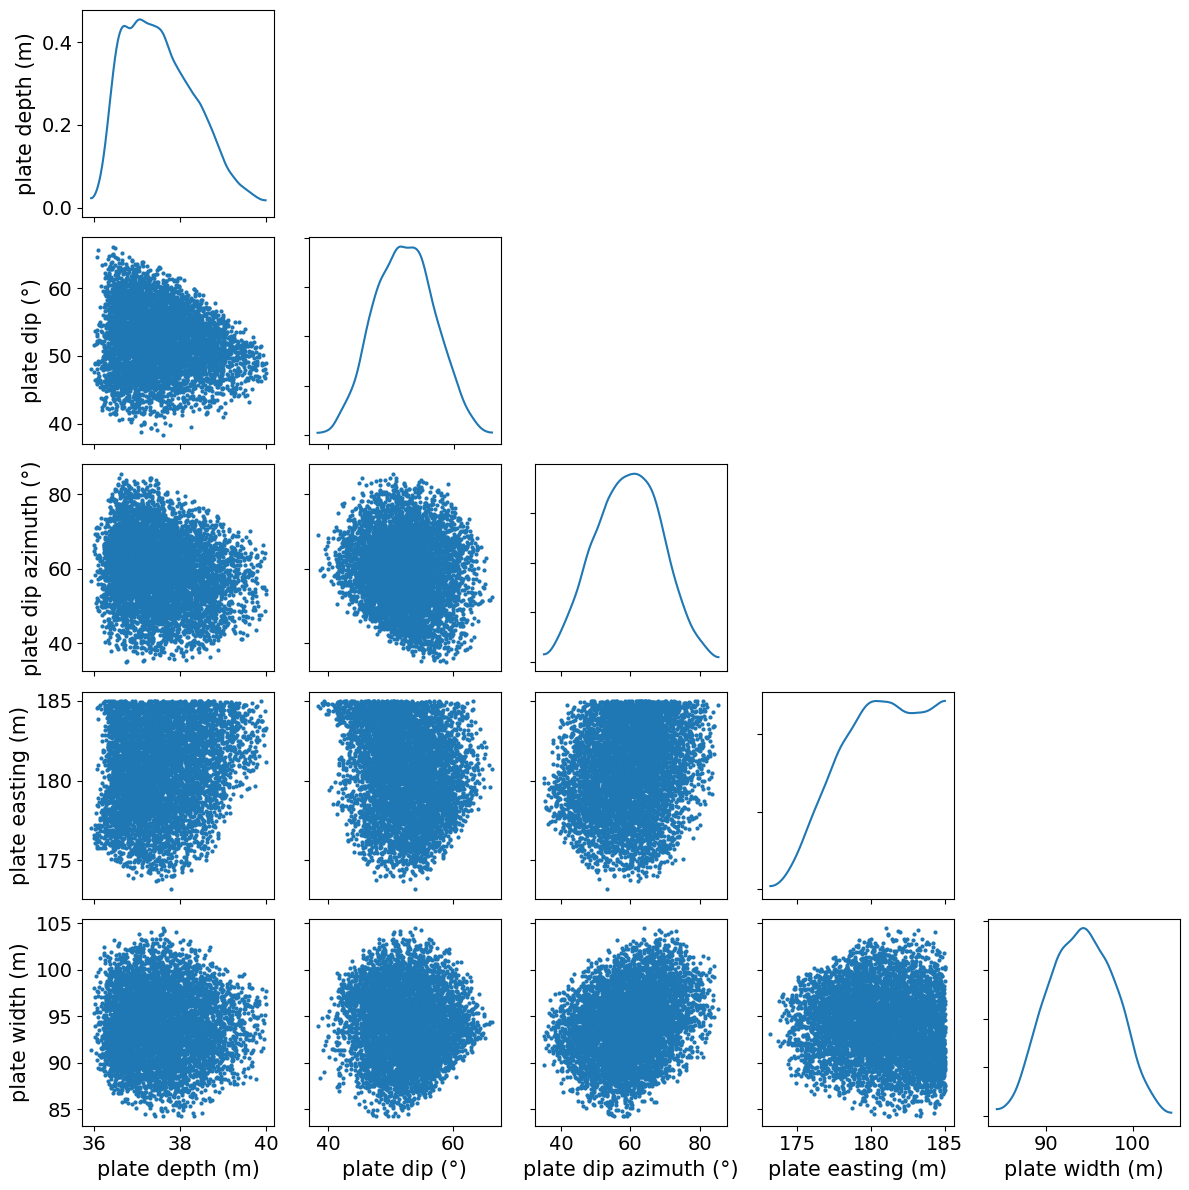

In [40]:
arviz.style.use("default")

_, axes = plt.subplots(5, 5, figsize=(12,12))
arviz.plot_pair(
    az_idata.sel(draw=slice(4000,None)), 
    marginals=True, 
    ax = axes
)
plt.tight_layout()

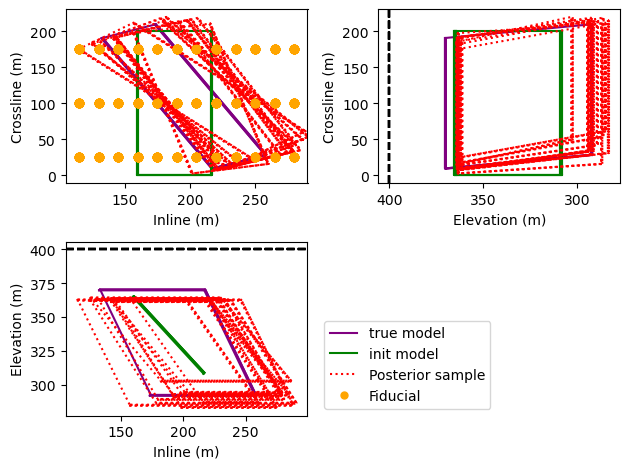

In [47]:
arviz.style.use("default")

_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="true model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="init model"
)


plt.tight_layout()


ichain=0
idraw=2500
sample=numpy.zeros(5)

sample[0]=az_idata.posterior['plate dip (\u00b0)'][ichain][idraw]
sample[1]=az_idata.posterior['plate dip azimuth (\u00b0)'][ichain][idraw]
sample[2]=az_idata.posterior['plate easting (m)'][ichain][idraw]
sample[3]=az_idata.posterior['plate depth (m)'][ichain][idraw]
sample[4]=az_idata.posterior['plate width (m)'][ichain][idraw]
plot_plate_faces(
    "plate_inverted", forward, sample, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="Posterior sample", linestyle="dotted"
)

point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")


# plot 10 randomly selected samples of the posterior distirbution
for i in range(10):
    idraw=numpy.random.randint(2000,5000)
    sample[0]=az_idata.posterior['plate dip (\u00b0)'][ichain][idraw]
    sample[1]=az_idata.posterior['plate dip azimuth (\u00b0)'][ichain][idraw]
    sample[2]=az_idata.posterior['plate easting (m)'][ichain][idraw]
    sample[3]=az_idata.posterior['plate depth (m)'][ichain][idraw]
    sample[4]=az_idata.posterior['plate width (m)'][ichain][idraw]
    plot_plate_faces(
    "plate_inverted", forward, sample, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="Posterior sample", linestyle="dotted"
)


---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [20]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
numpy 2.0.1
scipy 1.14.0
matplotlib 3.9.1.post1
